In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys

# Preprocessing for image

In [17]:
#Function that generates absolute sobel threshold for a given gray img.
def abs_sobel_thresh(gray,thresh):
   
    """   
    :param gray: input image 
    :param thresh: min and max threshold values    
    :return: returns the absolute sobel thresholded image
    """ 
    # Apply x gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # create a zero numpy array with the same size as scaled_sobel
    binary_output = np.zeros_like(scaled_sobel)
    # apply threshold
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return the result
    sobel_mask = binary_output
    return sobel_mask

#Function that generates combined threshold for a given img.
def binary_thresholded(img):
    
    """
    :param img: input image 
    :return: returns the combined thresholded image
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Getting image size
    height, width = gray.shape  
    # Apply absolute sobel threshold for the x gradient 
    grad_x = abs_sobel_thresh(gray, thresh=(10, 200))
    #Combining input from the two thresholds
    combined = ((grad_x == 1))
    #plt.imshow(grad_x)
    #plt.show()
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    # Creating an all zeros numpy array with the same size as the R channel
    color_combined = np.zeros_like(R)
    # Apply thresholds to the R and G channel
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    # Convert from rgb to hls color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #threshold for s_channel
    s_thresh=(100, 255)
    #threshold for l_channel
    l_thresh=(120, 255)
    # Getting the S channel    
    s_channel = hls[:,:,2] 
    # Getting the L channel
    l_channel = hls[:,:,1]
    # Apply thresholds to the S channel 
    s_condition = (s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])
    
    # Apply thresholds to the L channel
    l_condition = (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])
    
    # Combine the two thresholds
    color_combined[(r_g_condition & l_condition) & (s_condition | combined)] = 1

    return color_combined



# Prespective view

In [18]:
#Function that generates perspective warp for a given img.
def perspective_warp(img):

    """
    :param img: input image 
    :return: returns the perspective warped image
    """ 
    dst_size=(1280,720)
    src=np.float32([(0.38,0.7),(0.63,0.7),(0.1,1),(1,1)])
    dst=np.float32([(0,0), (1, 0), (0,1), (1,1)])
    print(img.shape[0])
    # getting image size
    img_size = np.float32([(img.shape[1],img.shape[0])])
    # mapping warping points in the source image
    src = src* img_size
    #print(src)
    # mapping warping points in the destination image
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    #plt.imshow(warped)
    #plt.show()
    return warped

#Function that generates inverse perspective warp for a given img.
def inv_perspective_transform(img):
    """
    :param img: input image 
    :return: returns the inverse perspective warped image
    """
    
    dst_size=(1280,720)
    src=np.float32([(0,0), (1, 0), (0,1), (1,1)])
    dst=np.float32([(0.38,0.7),(0.63,0.7),(0.1,1),(1,1)])
    # getting image size 
    img_size = np.float32([(img.shape[1],img.shape[0])])
    # mapping warping points in the source image
    src = src * img_size    
    # mapping warping points in the destination image
    dst = dst * np.float32(dst_size)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, dst_size)
    #plt.imshow(warped)
    #plt.show()
    return warped


In [19]:
#get histogram of image
def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

# sliding window algorithm

In [20]:
left_a, left_b, left_c = [],[],[]
right_a, right_b, right_c = [],[],[]
def sliding_window(img):
    """
    Function that generates a sliding window for a given img.
    :param img: input image 
    :return: returns out_img, and the left and right lane lines
    """ 
    global left_a, left_b, left_c,right_a, right_b, right_c 
    left_fit_= np.empty(3)
    right_fit_ = np.empty(3)

    # Creating a three channel to apply the sliding window
    out_img = np.dstack((img, img, img))*255

    # Getting the histogram of the image
    histogram = get_hist(img)

    # find peaks of leftmost and rightmost quarters
    midpoint = int(histogram.shape[0]/4)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint*3:]) + midpoint*3
    
    #parameters for sliding window
    nwindows=9
    margin=150 
    minpix = 1
    
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image        
        if 1:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (100,255,255), 3) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (100,255,255), 3) 
           
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        
        if len(good_right_inds) > minpix: 
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


    # Concatenate the arrays of indices)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    
    if(left_lane_inds.size > 1500 and right_lane_inds.size > 1500):
        left_fit = np.polyfit(lefty, leftx, 2)  

        left_a.append(left_fit[0])
        left_b.append(left_fit[1])
        left_c.append(left_fit[2])
        
        right_fit = np.polyfit(righty, rightx, 2)   
        
        right_a.append(right_fit[0])
        right_b.append(right_fit[1])
        right_c.append(right_fit[2])   
        
        
    left_fit_[0] = np.mean(left_a[-10:])
    left_fit_[1] = np.mean(left_b[-10:])
    left_fit_[2] = np.mean(left_c[-10:])
    
    right_fit_[0] = np.mean(right_a[-10:])
    right_fit_[1] = np.mean(right_b[-10:])
    right_fit_[2] = np.mean(right_c[-10:])
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    left_fitx = left_fit_[0]*ploty**2 + left_fit_[1]*ploty + left_fit_[2]
    right_fitx = right_fit_[0]*ploty**2 + right_fit_[1]*ploty + right_fit_[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [0, 255, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [255, 255, 0]
    
    return out_img, (left_fitx, right_fitx)

# Draw lanes

In [21]:
#Draw the detected lane lines on the input image
def draw_lanes(img, left_fit, right_fit):
    """
    :param img: input image 
    :param left_fit: coefficients of the left lane line polynomial
    :param right_fit: coefficients of the right lane line polynomial    
    :return: returns the image with the lane lines drawn on it
    """ 
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    color_img = np.zeros_like(img)

    left = np.array([np.transpose(np.vstack([left_fit, ploty]))])
    right = np.array([np.flipud(np.transpose(np.vstack([right_fit, ploty])))])
    
    points = np.hstack((left, right))
    
    cv2.polylines(color_img, np.int32(left), False, color=(0, 255, 0), thickness=25)
    cv2.polylines(color_img, np.int32(right), False, color=(255, 255, 0), thickness=25)

    cv2.fillPoly(color_img, np.int_(points), (0,0,255))
    inv_perspective = inv_perspective_transform(color_img)
    inv_perspective = cv2.addWeighted(img, 1, inv_perspective, 0.7, 0)
    return inv_perspective,color_img

# calculate curvature of road

In [22]:
# Calculate the radius of curvature in meters for both lane lines
def get_curvature(img, leftx, rightx):
    """
    :param img: input image 
    :param leftx: x-values of the left lane line pixels
    :param rightx: x-values of the right lane line pixels    
    :return: radius of curvature of left and right lane lines in meters, and the offset of the vehicle from the center of the lane
    """ 
    # Define conversions in x and y from pixels space to meters
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    # We'll choose the maximum y-value
    y_eval = np.max(ploty)
    ym_per_pix = 30.5/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/720 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # getting the offset of the vehicle from the center of the lane
    car_pos = img.shape[1]/2
    l_fit_x_int = left_fit_cr[0]*img.shape[0]**2 + left_fit_cr[1]*img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*img.shape[0]**2 + right_fit_cr[1]*img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    center = (car_pos - lane_center_position) * xm_per_pix / 10
    # Now our radius of curvature is in meters
    return (left_curverad, right_curverad, center)

# Debug video

In [23]:
def video_debug(img):
    #print(img.shape)
    threshold_img = binary_thresholded(img)
    #print(threshold_img.shape)
    #plt.imshow(threshold_img)
    #plt.show()
    img_warp = perspective_warp(threshold_img)
    out_img, curves= sliding_window(img_warp)
    #plt.imshow(out_img)
    #plt.show()
    final_img,color_img = draw_lanes(img,curves[0], curves[1])
      
    #dimensions of each pipeline image
    final_img_size = (854, 480)
    vertical_img_size = (426, 240)
    horizontal_img_size = (427, 240)
    #print('out_img.shape)
     
    #convert warped and thresholded image to 3 channels in order to be concatenated with the other images
    warped_original_img = np.zeros_like(img)
    warped_original_img[:,:,0] = img_warp * 255
    warped_original_img[:,:,1] = img_warp * 255
    warped_original_img[:,:,2] = img_warp * 255
    threshold_image = np.zeros_like(img)
    threshold_image[:,:,0] = threshold_img * 255
    threshold_image[:,:,1] = threshold_img * 255
    threshold_image[:,:,2] = threshold_img * 255
    
    
    #resize pipeline images to be stacked in one image
    original_img = cv2.resize(img, (vertical_img_size[0], vertical_img_size[1]))
    warped_original_img = cv2.resize(warped_original_img, (vertical_img_size[0], vertical_img_size[1]))
    thresholded_image = cv2.resize(threshold_image, (vertical_img_size[0], vertical_img_size[1]))
    sliding_window_img = cv2.resize(out_img, (horizontal_img_size[0], horizontal_img_size[1]))
    colored_lane_img = cv2.resize(color_img, (horizontal_img_size[0], horizontal_img_size[1]))
    final_img = cv2.resize(final_img, (final_img_size[0], final_img_size[1]))

    #stack some images vertically
    vertical_images = cv2.vconcat([original_img, warped_original_img, thresholded_image])

    #stack some images horizontally
    horizontal_images = cv2.hconcat([sliding_window_img, colored_lane_img])

    #stack final image vertically with the horizontal images
    stacked_vertical = cv2.vconcat([final_img, horizontal_images])
      
    #stack the result horizontally with the vertical images
    result = cv2.hconcat([stacked_vertical, vertical_images])
    return result

In [29]:
def Pipeline(img):
    threshold_img = binary_thresholded(img)
    #plt.imshow(threshold_img)
    #plt.show()

    img_warp = perspective_warp(threshold_img)
    out_img, curves= sliding_window(img_warp)
    #print('gg')
    #plt.imshow(out_img)
    #plt.show()
    final_img,color_img = draw_lanes(img,curves[0], curves[1])
    curverad = get_curvature(img, curves[0], curves[1])
    lane_curve = np.mean([curverad[0], curverad[1]])
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    fontSize=0.7
    cv2.putText(final_img, 'Lane Curvature: {:.0f} m'.format(lane_curve), (540, 620), font, fontSize, fontColor, 2)
    cv2.putText(final_img, 'Vehicle offset: {:.4f} m'.format(curverad[2]), (540, 650), font, fontSize, fontColor, 2)

    
    return final_img

# Test images

720


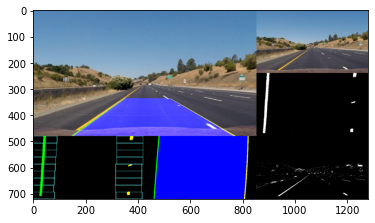

720


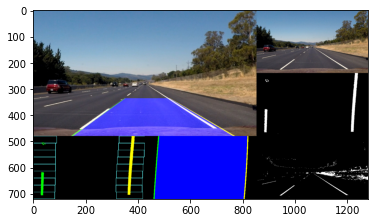

720


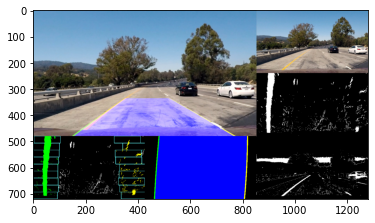

720


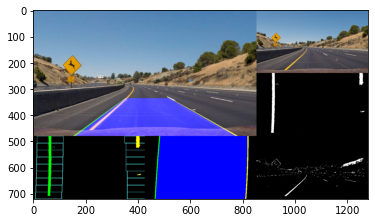

720


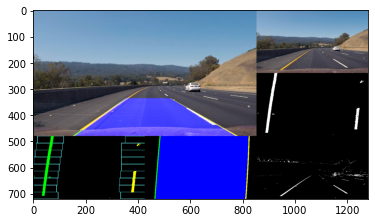

720


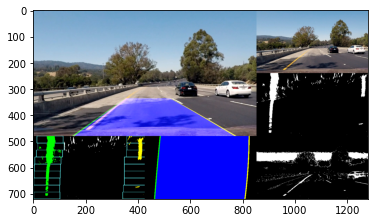

720


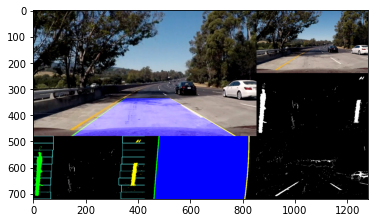

720


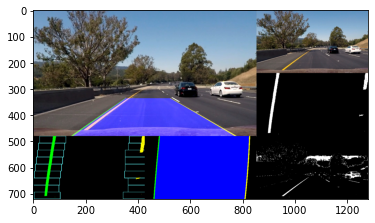

In [30]:
import glob
images = glob.glob('test_images/*.jpg')

for indx, image in enumerate(images):
    plt.imshow(video_debug(cv2.cvtColor(cv2.imread(image), cv2.COLOR_BGR2RGB)))
    plt.show()

# Test video

In [31]:
from moviepy.editor import VideoFileClip
def process_video(input_path,output_path):
    myclip = VideoFileClip(input_path)
    output_vid = output_path
    clip = myclip.fl_image(Pipeline)
    clip.write_videofile(output_vid, audio=False)
    myclip.reader.close()
    myclip.close()
def debug_video(input_path,output_path):
    myclip = VideoFileClip(input_path)#.subclip(40,43)
    output_vid = output_path
    clip = myclip.fl_image(video_debug)
    clip.write_videofile(output_vid, audio=False)
    myclip.reader.close()
    myclip.close()

In [32]:
input_path = sys.argv[1]
output_path = sys.argv[2]
mood = sys.argv[3]
if(mood == '--debugmood'):
    debug_video(input_path,output_path)
else:
    process_video(input_path,output_path)

IndexError: list index out of range